In [1]:
from keras.layers import Dense,LSTM,Input,Concatenate,Embedding,add,Dropout
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import keras
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.applications.inception_v3 import InceptionV3

In [8]:
X_train=pd.read_csv("Data\\train.csv") #1k unique image repeated times ith different caption
print(X_train.shape)
X_train.head()

(32364, 2)


,image,output
0,3025334206_76888792e5.jpg,start two dogs are running on the grass in fro...
1,2415803492_56a673dc25.jpg,start man wearing black dances with young girl...
2,2448393373_80c011d301.jpg,start little boy plays baseball with himself end
3,2198484810_50a893824a.jpg,start brown dog jumps over an obstacle end
4,3545586120_283d728a97.jpg,start two boxers with white gloves are fightin...


In [9]:
X_train["image"].unique().shape

(8090,)

# lets find Max_length

In [10]:
# lets find out the maximum length sentnece in our sentences
def max_length(df):
    max_length=0
    for i in df["output"]:
        le=len(i.split(" "))
        if le>max_length:
            max_length=le
    return max_length
max_length=max_length(X_train)
max_length

34

In [11]:
f=open("Data\\idx_to_word.json")
idx_to_word=json.load(f)
f1=open("Data\\word_to_idx.json")
word_to_idx=json.load(f1)

In [12]:
len(idx_to_word),len(word_to_idx)

(8082, 8082)

# Lets prepare our input and output that has to be given to our model

In [16]:
#reading the file that have the vector repreentation of our 2k ditinct images

vocab_size=len(idx_to_word)
number_of_images=3
epochs=10

f=open("Data\\image_to_vectors_8k.json")
img2vec=json.load(f)

#storing each word and corresponding vector into glove_vector dictionary
file=open("Data\\glove.6B.200d.txt",encoding="utf-8")
glove_vectors={}
for line in file:
    values=line.split()
    word=values[0]
    vector=np.asarray(values[1:],dtype="float32").tolist()
    glove_vectors[word]=vector

In [17]:
def data_generator():
    global img2vec,glove_vectors,X_train,number_of_images,vocab_size,max_length,word_to_idx
    X1,X2,y=[],[],[] #X1 stores vector of image and X2 stores the sequence vector and y stores the OHE of vocabsize
    n=0
    unique_images=X_train["image"].unique()
    while 1:
        for img in unique_images:
            n=n+1
            for index,row in X_train[X_train["image"]==img].iterrows():
                seq=row["output"].split(" ")
                for i in range(1,len(seq)):
                    X1.append(np.array(img2vec[row["image"]]).flatten()) #since each vector is 2d so i am flattening to make 1d  then appending
                    #X1.append(row["image"])
                    in_seq=[]
                    for j in seq[:i]:
                        try:
                            in_seq.append(glove_vectors[j])
                            #in_seq.append(j)
                        except:
                            pass
                    X2.append(in_seq)
                    w=np.zeros(vocab_size,dtype="int8")
                    w[word_to_idx[seq[i]]]=1
                    y.append(w)
            
            if n==number_of_images:
                X2=pad_sequences(X2,maxlen=max_length,dtype="float32")
                X2=np.array(X2)
                X1=np.array(X1)
                y=np.array(y)
                yield (X1,X2),y
                X1,X2,y=[],[],[]
                n=0
            
#print(next(data_generator()))

In [11]:
(x1,x2),y=data_generator().__next__()

In [12]:
len(list(y[17]))

8082

In [13]:
x1.shape,x2.shape,y.shape

((110, 2048), (110, 34, 200), (110, 8082))

# Modelling

In [14]:
inputA=Input(shape=(2048,))
inputB=Input(shape=(None,200))
fe1 = Dropout(0.5)(inputA)
i_model=Dense(256,activation="relu")(fe1) #image_model
#i_model=Model(inputs=inputA,outputs=i_model) #this will serve as model you can give input of 25088 in i_model.predict(25088) vector it will return 200 d vector if you give like this
fe2 = Dropout(0.5)(inputB)
s_model=LSTM(256)(fe2) #sequence_model
#s_model=Model(inputs=inputB,outputs=s_model)
#combined=add([i_model.output,s_model.output]) #(Batchsize,(shape))--->this is how shape is determined
combined=add([i_model,s_model])
f_model=Dense(256)(combined) #final_model
z=Dense(vocab_size,activation="softmax")(f_model)
model=Model(inputs=[inputA,inputB],outputs=z)
#model=Model(inputs=[i_model.input,s_model.input],outputs=z) #we can give like this also since each model we created as model

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None, 200)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 2048)              │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, None, 200)         │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         524,544 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 256)               │         467,968 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dense[0][0], lstm[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │          65,792 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 8082)              │       2,077,074 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,135,378 (11.96 MB)

 Trainable params: 3,135,378 (11.96 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=["accuracy"])

In [18]:
epochs=10
steps=len(X_train["image"].unique())//number_of_images
generator=data_generator()
for i in range(epochs):
    model.fit(generator,verbose=1,epochs=1,steps_per_epoch=steps)

2696/2696 ━━━━━━━━━━━━━━━━━━━━ 583s 216ms/step - accuracy: 0.2858 - loss: 3.6841
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 589s 218ms/step - accuracy: 0.2997 - loss: 3.4861
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 614s 228ms/step - accuracy: 0.3070 - loss: 3.3420
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 622s 231ms/step - accuracy: 0.3134 - loss: 3.2387
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 626s 232ms/step - accuracy: 0.3205 - loss: 3.1494
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 624s 232ms/step - accuracy: 0.3259 - loss: 3.0871
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 628s 233ms/step - accuracy: 0.3309 - loss: 3.0298
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 631s 234ms/step - accuracy: 0.3353 - loss: 2.9901
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 637s 236ms/step - accuracy: 0.3382 - loss: 2.9509
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 510s 189ms/step - accuracy: 0.3419 - loss: 2.9183


In [19]:
model.save("Data\\image_caption_model_1.keras")

In [20]:
epochs=10
steps=len(X_train["image"].unique())//number_of_images
generator=data_generator()
for i in range(epochs):
    model.fit(generator,verbose=1,epochs=1,steps_per_epoch=steps)


2696/2696 ━━━━━━━━━━━━━━━━━━━━ 454s 168ms/step - accuracy: 0.3478 - loss: 2.8746
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 455s 169ms/step - accuracy: 0.3488 - loss: 2.8620
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 462s 171ms/step - accuracy: 0.3510 - loss: 2.8389
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 465s 172ms/step - accuracy: 0.3530 - loss: 2.8200
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 466s 173ms/step - accuracy: 0.3553 - loss: 2.7995
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 465s 172ms/step - accuracy: 0.3570 - loss: 2.7844
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 468s 174ms/step - accuracy: 0.3573 - loss: 2.7740
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 470s 174ms/step - accuracy: 0.3594 - loss: 2.7584
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 469s 174ms/step - accuracy: 0.3611 - loss: 2.7421
2696/2696 ━━━━━━━━━━━━━━━━━━━━ 472s 175ms/step - accuracy: 0.3623 - loss: 2.7350


In [21]:
model.save("Data\\image_caption_model_2.keras")

In [22]:
number_of_images=6
epochs=10
model.optimizer.lr = 0.0001
steps=len(X_train["image"].unique())//number_of_images
generator=data_generator()
for i in range(epochs):
    model.fit(generator,verbose=1,epochs=1,steps_per_epoch=steps)


1348/1348 ━━━━━━━━━━━━━━━━━━━━ 398s 295ms/step - accuracy: 0.3746 - loss: 2.6472
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 398s 295ms/step - accuracy: 0.3789 - loss: 2.6132
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 399s 296ms/step - accuracy: 0.3811 - loss: 2.6003
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 395s 293ms/step - accuracy: 0.3826 - loss: 2.5857
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 390s 289ms/step - accuracy: 0.3838 - loss: 2.5751
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 390s 290ms/step - accuracy: 0.3852 - loss: 2.5651
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 401s 298ms/step - accuracy: 0.3870 - loss: 2.5528
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 402s 298ms/step - accuracy: 0.3871 - loss: 2.5484
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 401s 297ms/step - accuracy: 0.3880 - loss: 2.5361
1348/1348 ━━━━━━━━━━━━━━━━━━━━ 403s 299ms/step - accuracy: 0.3888 - loss: 2.5348


In [23]:
model.save("Data\\image_caption_model_3.keras")

# Evaluation

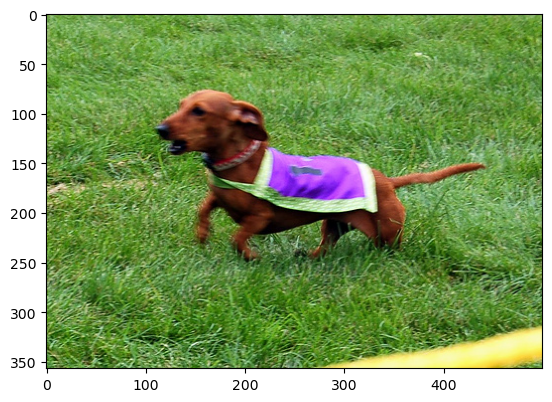

In [41]:
import matplotlib.pyplot as plt
x=plt.imread("Images\\241046599_28b0ca7b9f.jpg")
plt.imshow(x)
plt.show()

In [18]:
import warnings
warnings.filterwarnings("ignore")
def caption_generator(photo):
    
    global max_length,idx_to_word,glove_vectors,img2vec
    
    image=np.array(img2vec[photo]).reshape(1,2048)
    
    model=keras.saving.load_model("Models\\image_caption_model_3.keras")
    
    in_text="start"
    for i in range(max_length):
        L=[]
        for j in in_text.split(" "):
            try:
                L.append(glove_vectors[j])
            except:
               pass
        seq=pad_sequences([L],maxlen=max_length,dtype="float32")
        pred=model.predict([image,seq],verbose=0)
        index=np.argmax(pred)
        next_word=idx_to_word[str(index)]
        if next_word == "end":
            break
        in_text=in_text+" "+next_word
    return in_text[6:]
print(caption_generator("241046599_28b0ca7b9f.jpg"))

brown dog is running through tall grass
